## Optimal Control on the Microscale using JAX

In this notebook we want to give a short over view on how we use the JAX package to solve optimcal control problems on the microscale. For the reader that is unfamiliar with the `JAX` package a short overview over the most important functions form the package is given in the beginning. Subsequently we show how to solve the the problem that was analytically solved by [Schmiedel & Seifert in 2007](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.108301) using `JAX` and `optax`. At this point we have to mention that a similar approach was previously established by [Engel et al.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041032) has inspired our method.

## Technical remarks
Befor starting we recommend setting up Windows subsystem for Linux (WSL - if you are not working on a linux machine) and then creating a virtual environment that includes all required packages. This is done as follows:
- install [WSL](https://documentation.ubuntu.com/wsl/en/latest/guides/install-ubuntu-wsl2/)
- everything that follows happens in the WSL command line
- install [anaconda](https://docs.anaconda.com/anaconda/install/linux/)
- create a conda environment  
    `conda create -n my_environment`
- activate the environment  
    `conda activate my_environment`
- install python in the evironment  
    `conda install python=3.12.7`
- install all required package using the `setup.py` file (which uses the `requirements.txt` file)  
    `pip install .`  
Now you should be able to use `jit`, `vmap`, `grad`and all the other tools in `jax`. Before starting however, I recommend taking a look in the [documentation](https://jax.readthedocs.io/en/latest/) especially at the [sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) so you do not get surprised by some special requirements of `jax`.

### Warning
`jax` by default uses `float32` precision this can lead to numerical errors of unexpected extend when for example doing langevin dynamic simulations. It is possible to force `jax`to use `float64`precision like this: 
    `jax.config.update("jax_enable_x64",True)`  
This might have other draw backs, for more infos see the [documentation](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision).


## Using the JAX python package: A hands on Tutorial

*"JAX is a library for array-oriented numerical computation (à la NumPy), with automatic differentiation and JIT compilation to enable high-performance machine learning research."*

Three are three main features, so called transformers:
- just in time compilation $\rightarrow$ make code fast
- automitc vectorization $\rightarrow$ allows batch processing of data
- **automatic differentiation** $\rightarrow$ enables optimization of complex problems

## Automatic Differentiation
This is based on the chain rune of calculus:
$$
\begin{align*}
F(X) &= f(g(h(x)))\\
F'(x) &= f'((g(h(x))) \cdot g'(h(x)) \cdot h'(x)\\
&= f'(w_2) \cdot g'(w_1) \cdot h'(x)\\
&= \frac{\partial f}{\partial w_2} \cdot \frac{\partial g}{\partial w_1} \cdot \frac{\partial h}{\partial x}
\end{align*}
$$
This can also be applied to programming functions. They can be decomposed in basic functions i.e. addition, substraction, exponential etc. of which exact derivatives are known. By decomposing complex function and then backpropagating through them derivatives can be computed. This is the basis of gradient based optimization of artificial neural networks.

### Code Example

In [ ]:
from jax import grad
import jax.numpy as jnp

# define a function
def func(x):
    return x**2

# calculate the gradient of the function with respect to its single input
grad_func = grad(func)  # this is function again

# calculate the gradient at a given input value
print(grad_func(2.))


## Autoamtic vectorization

Using the `vmap`function we can vectorize function and therby evalute data in batches.

Computation using for loop took:  0:00:00.209404  s
Computation using vmap took:  0:00:00.002824  s


Text(0, 0.5, 'df/dx')

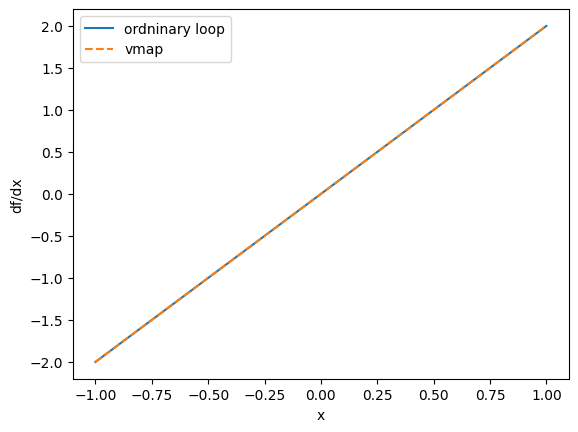

In [ ]:
from jax import vmap
from datetime import datetime
import matplotlib.pyplot as plt

#  we want to calculate the gradient as before but at many values of x
x = jnp.linspace(-1,1,100)

# OPTION1: Calculating with Loop
# Note - This will lead to an error:
# dfdx = grad_func(x)
# TypeError: Gradient only defined for scalar-output functions. Output had shape: (100,).
# therfore we need to do a loop

dfdx = jnp.zeros(x.shape)

starttime = datetime.now()

for i in range(len(x)):
    dfdx = dfdx.at[i].set(grad_func(x[i])) # jax arrays are imutable

print("Computation using for loop took: ",datetime.now() - starttime," s")

# Option2: Calculating with vmap
starttime = datetime.now()
dfdx_vmap = vmap(grad_func)(x)
print("Computation using vmap took: ",datetime.now() - starttime," s")

# plot results for comparision if we actually calculated the same
plt.figure()
plt.plot(x,dfdx,label="ordninary loop")
plt.plot(x,dfdx_vmap,linestyle="--",label="vmap")
plt.legend()
plt.xlabel("x")
plt.ylabel("df/dx")

## Just in time compilation
Speed thing up!

In [ ]:
from jax import jit

x = jnp.linspace(-1,1,100)

fast_grad_func = jit(vmap(grad_func))

print("Slow grad func:")
%timeit vmap(grad_func)(x).block_until_ready()

print("Fast grad func:")
_ = fast_grad_func(x) # the first call will take longer due to compilation and we dont want to time this
%timeit fast_grad_func(x).block_until_ready()


Slow grad func:
1.44 ms ± 11.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Fast grad func:
6.19 μs ± 195 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Optimal Control at the micro scale

We want to optimize the established control problem [Schmiedel & Seifert PRL 2007](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.108301) of shifting a harmonic trap over a distance $\lambda_f$ in a finite time $t_f$ while it is holding an overdamped particle. This operation shall be executed as work efficiently as possible.\\
The particle with position $x$ is held in potential with center $\lambda$.
$$V = \kappa (x - \lambda)^2$$
Changing the potential postion requires work:
$$ 
W = \int_{0}^\infty \frac{\partial V}{\partial \lambda} \dot{\lambda} \mathrm{d}t 
$$
The optimal protocol $\lambda^*$ requieres the lowest amount of work. As an Ansatz for our protocol we choose a picewise linear function, which is defined by $N$ parameters $\lambda_N$:
$$
\begin{align*}
&f(x) = \frac{\lambda_{i+1} - \lambda_{i}}{\Delta x} \quad &\mathrm{for}&\quad x_{i} \leq x < x_{i+1}\\
&f(x) = \lambda_{N} \quad &\mathrm{for}& \quad x = x_{N}
\end{align*}
$$
We know optimize $\lambda_N$ using automatic differentiation in comibination with an  gradient descent optimization algorithm. Solving this problem in this way was first done by [Engel et al.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041032).


In [5]:
import jax.numpy as jnp     # basic utilities for array computation
from jax import jit         # just in time compilation
from jax import grad        # automatic differentiation
from jax import vmap        # vectorization
from jax.lax import scan    # loop optimized for jax

import optax                # optimization package for jax

import numpy as np
import matplotlib.pyplot as plt
from jax import value_and_grad

In [6]:

@jit # defines harmonic potential
def potential(x,l):
    return k/2 * (x-l)**2

@jit # update step for langevin simulation
def langevin_update_0K_lax(x,l):
    dx = - grad(potential,argnums=0)(x,l)/ g * dt
    x = x + dx
    return x, x

# whole simulation
def simulation_lax(x0,protocol):
    _, traj = scan(langevin_update_0K_lax,x0,protocol)
    return traj

# protocol parametrization
@ jit
def make_protocol_piecelin(ls):
    n = jnp.linspace(0,Nprot-1,Nprot)       # time steps in protocol, choose these inputs to cover both jumps
    dn = jnp.floor(Nprot/(len(ls)-1))       # time steps per segment

    # use len(ll)-2 because: n-1 segments, -1 because last lambda is just jump
    # len(funlist) has to be len(condlist) + 1

    condlist = [jnp.logical_and(i*dn <= n, n < (i+1)*dn)
                for i in range(len(ls))]  # list of conditions segmenting the protocol

    funclist = [lambda n, i=i: (ls[i+1]-ls[i])/dn*n + (i+1)*ls[i] - i*ls[i+1]
                 for i in range(len(ls))] # linear function for each segment

    funclist.append(lf)                 # append jump to the fixed final position
    lp = jnp.piecewise(n, condlist, funclist) # calculate protocol

    #  stitch together whole lambda
    Li = jnp.ones(Npre)*li  # position before protocol
    Lp = lp + li            # protocol
    Lf = jnp.ones(Npost)*lf # position after protocol
    return jnp.concat([Li,Lp,Lf])

@jit # calculate work from trajectory and protocol using Stratonovich convention
def WofXandL(traj,protocol):
    dVdl = vmap(grad(potential,argnums=1),0)(traj,protocol)
    dVdlstr = (dVdl[1:] + dVdl[:-1])/2

    dl = jnp.diff(protocol,1,0)

    W = jnp.sum(dVdlstr[Npre-1:] * dl[Npre-1:])
    return W

# IMPORTANT FUNCTION: W as function of protocol parameteres
def Wfunc_lax(lambdas):
    protocol = make_protocol_piecelin(lambdas)
    traj = simulation_lax(x0,protocol)
    W = WofXandL(traj,protocol)
    return W

In [ ]:
# system parameters - arbitrary values
k = 1.      # trap stiffness
g = 1.      # particle friction
dt = 0.1    # simulation update time step
x0 = 0.     # starting particl position
Npre = 100  # number of sim steps before protocol
Nprot = 100 # number of sim steps during protocol, tf = dt*Nprot
Npost = 100 # number of sim steps after protocol
Nstep = Npre+Nprot+Npost
tf = Nprot * dt
li = 0.     # startong trap positon
lf = 1.     # final trap position

In [ ]:
# initialize optimizer
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
opt_params = jnp.array([0., 0., 0., 0., .0]) # parameters for lin. parametrization
opt_state = optimizer.init(opt_params)

# number of optimization steps
num_opt_it = 200

# collect parameters
param_col = np.zeros((num_opt_it,len(opt_params)))

# function with a single optimization update
@jit
def opt_step(carry,_):
  opt_params, opt_state = carry
  loss, grads = value_and_grad(Wfunc_lax)(opt_params)
  updates, opt_state = optimizer.update(grads, opt_state)   # calculate update
  opt_params = optax.apply_updates(opt_params, updates)             # apply update
  return (opt_params, opt_state), loss

# execute optimization, simple for loop would also do the job
(opt_params_out, opt_state), losses = scan(opt_step,(opt_params, opt_state),None,length=num_opt_it)

Text(0, 0.5, '$W$')

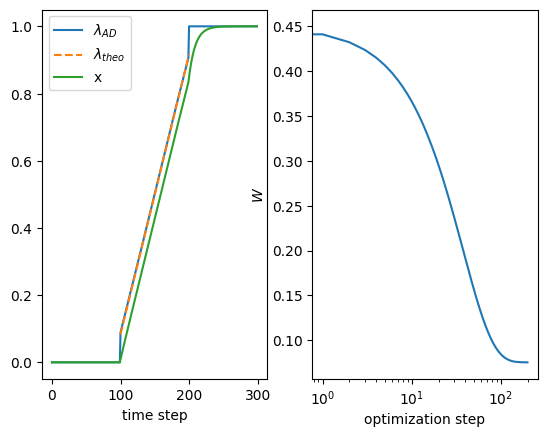

In [13]:
# Plot results

# prediction for optimal protocol from schmiedel and seifert
theo = lambda t: (lf/(2+(tf/(g/k))))*(1+t/(g/k))

protocol = make_protocol_piecelin(opt_params_out)
traj = simulation_lax(x0,protocol)

fig, axs = plt.subplots(1,2)
axs[0].plot(protocol,label=r'$\lambda_{AD}$')
axs[0].plot(np.linspace(Npre,Nprot+Npre,Nprot),theo(np.linspace(0,tf,Nprot)),label=r'$\lambda_{theo}$',linestyle="--")
axs[0].plot(traj,label=r'x')
axs[0].legend()
axs[0].set_xlabel("time step")

axs[1].semilogx(losses)
axs[1].set_xlabel("optimization step")
axs[1].set_ylabel(r'$W$')

The optimization routine yields the same result as the prediction from Schmiedel & Seifert.